# Deep learning with tensorflow for linear inverse problem

### Importation

In [2]:
import numpy as np
import math
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'1.3.0'

### Data

We are going to solve numerically with neural network a very simple inverse problem.
Let us consider the linear bounded operator 
$ K: \mathscr{X} \to \mathscr{Y}$ with $\mathscr{X}$ and $\mathscr{Y}$ two Hilbert space.
Knowing an image $y$, we want to reconstruct $x$ such that $x = Ky$.

We suppose that $\mathscr{X} = L^2(a,b)$, $\mathscr{Y} = L^2(a,b)$, with $a,b \in \mathbb{R}^+$,  
$$ y (t) = K x = \int_0^t \;  x(s) \mathrm{d} \; s $$
This problem is ill-posed of order 1.
Moreover, if $y$ is known with an error $\delta$
such that $\| y^\delta -y \|_{L^2} < \delta$,
then the optimal regularization method for $x \in H^1(a,b)$ 
gives a reconstruction with an error in $ O (\delta)$.

Let us construct a list of data. 
We suppose that $x$ is a gaussian distribution and compute the different integral $y = Kx$.

In [5]:
# Physical data
a = 0
b = 10

Let $(s_i)$ be a regular mesh of the segment $[a,b]$ with N+1 nodes and a step $ds$, 
and $X_i = x(s_i)$ an approximation of the function $x$.
The integral is approximated with the trapezoidal rule
$$ Y_i = \frac{1}{2} X_0 \; ds + \sum_{j=1}^{i-1}X_j \; ds + \frac{1}{2} X_i \; ds $$

In [6]:
# Numerical data
N = 100 # N intervals, N+1 nodes
ds = (b-a)/N
s_grid = np.linspace(a,b,N+1)

In [7]:
# Integral operator
K = ds*(np.tri(N+1,N+1) - 1/2*np.eye(N+1))
K[:,0] = 1/2*ds
print(K.shape)

(101, 101)


In [8]:
# Data set for training and testing
ndata = 50
label = np.zeros((ndata,N+1))
data = np.zeros((ndata,N+1))
for i in range(0,ndata):
    mu = random.uniform(0.01*(b-a),0.9*(b-a))
    sigma = random.uniform(1,5)
    label[i,:]=(sigma*np.sqrt(2*np.pi))**-1*np.exp(-(s_grid-mu)**2/2*sigma**2)
    data[i,:] =(K.dot(label[i,:]))

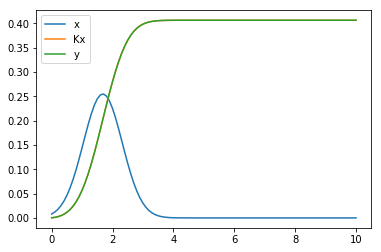

In [9]:
plt.plot(s_grid,label[10],label='x')
plt.plot(s_grid,K.dot(label[10]),label='Kx')
plt.plot(s_grid,data[10],label='y')
plt.legend()

We suppose that we measure $y$ with $N+1$ measurements,
and usually we want to reconstruct $x$ on only a certain percentage of the points (circa $25\%$), 
and we interpolate the result on a grid.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
y_train, y_test, x_train, x_test = train_test_split(data,label,test_size=0.3,random_state=101)

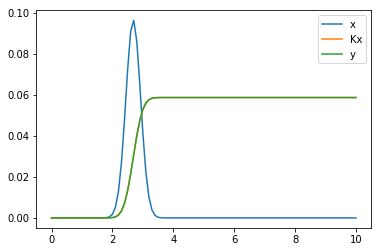

In [12]:
plt.plot(s_grid,x_train[5],label='x')
plt.plot(s_grid,K.dot(x_train[5]),label='Kx')
plt.plot(s_grid,y_train[5],label='y')
plt.legend()


### Neural network

We use an approximation of relu as activation function, it helps imposing the positivity of the solution.

In [13]:
#Placeholder
y=tf.placeholder(tf.float32,shape=[None,N+1])
# We create two layers
#Variables
W1=tf.Variable(tf.truncated_normal([N+1,101],stddev=0.1))
b1=tf.Variable(tf.zeros([101]))
W2=tf.Variable(tf.truncated_normal([101,101],stddev=0.1))
b2=tf.Variable(tf.zeros([101]))
W3=tf.Variable(tf.truncated_normal([101,N+1],stddev=0.1))
b3=tf.Variable(tf.zeros([N+1]))
#Graph 1
x1= tf.nn.relu6(tf.matmul(y,W1)+b1)
#Graph 2
x2= tf.nn.relu6(tf.matmul(x1,W2)+b2)
#Graph 3
x= tf.nn.relu6(tf.matmul(x2,W3)+b3)
#Loss function
x_true = tf.placeholder(tf.float32,[None,N+1])
loss = tf.reduce_sum((x-x_true)**2)
#Optimizer
optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

Step 0, loss = 21.79062843322754
Step 1000, loss = 6.225551605224609
Step 2000, loss = 5.690273284912109
Step 3000, loss = 5.527693271636963
Step 4000, loss = 5.448545455932617
Step 5000, loss = 5.396428108215332
Step 6000, loss = 5.356197357177734
Step 7000, loss = 5.328861236572266
Step 8000, loss = 5.304812431335449
Step 9000, loss = 5.283141613006592


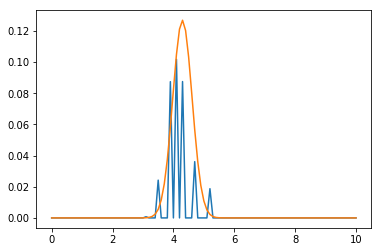

In [14]:
#Create session
Niter=10000
with tf.Session() as sess:
    sess.run(init)
    for step in range(Niter):
        sess.run(train,feed_dict={y:y_train,x_true:x_train})
        if step%1000==0:
            loss_train = sess.run(loss,feed_dict={y:data,x_true:label})
            print("Step {0}, loss = {1}".format(step,loss_train))
    x_pred = sess.run(x,feed_dict={y:data})
    plt.plot(s_grid,x_pred[5],label='x_pred')
    plt.plot(s_grid,label[5,:],label ='x')

### Comparaison with gradient descent for classical Tikhonov method

Here we predict the minimum of
$$ J(x) = \|Kx-y\|_{L^2(a,b)} + \alpha \|x\|_{L^2(a,b)}$$
(since we supposed that we know $y$ exactly, we could restrain ourselves with $\alpha =0$).

In [30]:
# Data
mu = random.uniform(0.01*(b-a),0.9*(b-a))
sigma = random.uniform(1,5)
x_true =(sigma*np.sqrt(2*np.pi))**-1*np.exp(-(s_grid-mu)**2/2*sigma**2)
y =(K.dot(x_true))


In [36]:
# Function and gradient 
def J(x,K,y,alpha):
    return np.linalg.norm(K.dot(x)-y)+alpha*np.linalg.norm(x)
def dJ(x,K,y,alpha):
    return 2*K.T.dot(K.dot(x)-y)+2*alpha*x

         Current function value: 0.000795
         Iterations: 32
         Function evaluations: 113
         Gradient evaluations: 101


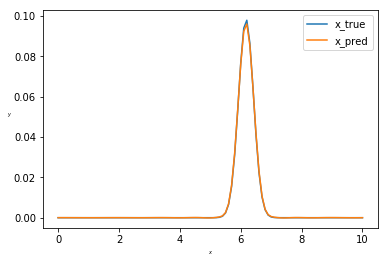

In [37]:
### GRADIENT PARAMETER
alpha = 0.001
# initial zeta
x0 = np.zeros(N+1)
resultat = minimize(J, x0,\
args =(K,y,alpha),\
method='BFGS',\
jac=dJ, \
tol=1e-6, \
options={'maxiter':120,'disp': True})


### Plots
plt.xlabel(u'$x$', fontsize=5)
plt.ylabel(u'$y$', fontsize=5, rotation=0)
plt.plot(s_grid, x_true, label= "x_true")
plt.plot(s_grid, resultat.x, label= "x_pred")
plt.legend()